<a href="https://colab.research.google.com/github/aman-garg0001/vehichle-number-plate-recognition/blob/main/object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 1.x
import tensorflow as tf
import keras
print(tf.__version__)
print(keras.__version__)

TensorFlow 1.x selected.
1.15.2
2.1.5


Using TensorFlow backend.


In [ ]:
!pip install keras==2.1.5

  Using cached https://files.pythonhosted.org/packages/ba/65/e4aff762b8696ec0626a6654b1e73b396fcc8b7cc6b98d78a1bc53b85b48/Keras-2.1.5-py2.py3-none-any.whl
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/Number Plate Recognition

/content/drive/MyDrive/Number Plate Recognition


In [ ]:
!git clone https://github.com/qqwweee/keras-yolo3

Cloning into 'keras-yolo3'...
remote: Enumerating objects: 144, done.
remote: Total 144 (delta 0), reused 0 (delta 0), pack-reused 144
Receiving objects: 100% (144/144), 151.08 KiB | 4.44 MiB/s, done.
Resolving deltas: 100% (65/65), done.


In [ ]:
!cp -r --recursive '/content/drive/MyDrive/Number Plate Recognition/Number-Plate-Dataset/Preprocessed_Images'  '/content/drive/MyDrive/Number Plate Recognition/keras-yolo3'
!cp -r --recursive '/content/drive/MyDrive/Number Plate Recognition/Number-Plate-Dataset/my_classes.txt'  '/content/drive/MyDrive/Number Plate Recognition/keras-yolo3'
!cp -r --recursive '/content/drive/MyDrive/Number Plate Recognition/Number-Plate-Dataset/train.txt'  '/content/drive/MyDrive/Number Plate Recognition/keras-yolo3'

In [ ]:
!cp -r --recursive '/content/drive/MyDrive/Trained_Models/yolo.h5'  '/content/drive/MyDrive/Number Plate Recognition/keras-yolo3/model_data'

In [ ]:
!cp -r --recursive '/content/drive/MyDrive/YOLO/yolov3.weights' '/content/drive/MyDrive/Number Plate Recognition/keras-yolo3'

In [ ]:
cd /content/drive/MyDrive/Number Plate Recognition/keras-yolo3

/content/drive/MyDrive/Number Plate Recognition/keras-yolo3


In [ ]:
!python convert.py yolov3.cfg yolov3.weights model_data/yolo_weights.h5

Using TensorFlow backend.
Loading weights.
Weights Header:  0 2 0 [32013312]
Parsing Darknet config.
Creating Keras model.


Parsing section net_0
Parsing section convolutional_0
conv2d bn leaky (3, 3, 3, 32)




2021-04-26 14:03:35.148063: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2200210000 Hz
2021-04-26 14:03:35.148877: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5637f8fe2a00 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-04-26 14:03:35.148925: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2021-04-26 14:03:35.192460: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-04-26 14:03:35.253570: E tensorflow/stream_executor/cuda/cuda_driver.cc:318] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-04-26 14:03:35.253644: I tensorflow/stream

In [ ]:
import shutil
import os
src = '/content/drive/MyDrive/Number Plate Recognition/keras-yolo3/Preprocessed_Images'
dst = '/content/drive/MyDrive/Number Plate Recognition/keras-yolo3/'
src_files = os.listdir(src)
for file_name in src_files:
    full_file_name = os.path.join(src, file_name)
    if os.path.isfile(full_file_name):
        shutil.copy(full_file_name, dst)

In [ ]:
import numpy as np
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from yolo3.model import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss
from yolo3.utils import get_random_data


def get_classes(classes_path):
    '''loads the classes'''
    with open(classes_path) as f:
        class_names = f.readlines()
    class_names = [c.strip() for c in class_names]
    return class_names

def get_anchors(anchors_path):
    '''loads the anchors from a file'''
    with open(anchors_path) as f:
        anchors = f.readline()
    anchors = [float(x) for x in anchors.split(',')]
    return np.array(anchors).reshape(-1, 2)


def create_model(input_shape, anchors, num_classes, load_pretrained=True, freeze_body=2,
            weights_path='model_data/yolo_weights.h5'):
    '''create the training model'''
    K.clear_session() # get a new session
    image_input = Input(shape=(None, None, 3))
    h, w = input_shape
    num_anchors = len(anchors)

    y_true = [Input(shape=(h//{0:32, 1:16, 2:8}[l], w//{0:32, 1:16, 2:8}[l], \
        num_anchors//3, num_classes+5)) for l in range(3)]

    model_body = yolo_body(image_input, num_anchors//3, num_classes)
    print('Create YOLOv3 model with {} anchors and {} classes.'.format(num_anchors, num_classes))

    if load_pretrained:
        model_body.load_weights(weights_path, by_name=True, skip_mismatch=True)
        print('Load weights {}.'.format(weights_path))
        if freeze_body in [1, 2]:
            # Freeze darknet53 body or freeze all but 3 output layers.
            num = (185, len(model_body.layers)-3)[freeze_body-1]
            for i in range(num): model_body.layers[i].trainable = False
            print('Freeze the first {} layers of total {} layers.'.format(num, len(model_body.layers)))

    model_loss = Lambda(yolo_loss, output_shape=(1,), name='yolo_loss',
        arguments={'anchors': anchors, 'num_classes': num_classes, 'ignore_thresh': 0.5})(
        [*model_body.output, *y_true])
    model = Model([model_body.input, *y_true], model_loss)

    return model




def data_generator(annotation_lines, batch_size, input_shape, anchors, num_classes):
    '''data generator for fit_generator'''
    n = len(annotation_lines)
    i = 0
    while True:
        image_data = []
        box_data = []
        for b in range(batch_size):
            if i==0:
                np.random.shuffle(annotation_lines)
            image, box = get_random_data(annotation_lines[i], input_shape, random=True)
            image_data.append(image)
            box_data.append(box)
            i = (i+1) % n
        image_data = np.array(image_data)
        box_data = np.array(box_data)
        y_true = preprocess_true_boxes(box_data, input_shape, anchors, num_classes)
        yield [image_data, *y_true], np.zeros(batch_size)

def data_generator_wrapper(annotation_lines, batch_size, input_shape, anchors, num_classes):
    n = len(annotation_lines)
    if n==0 or batch_size<=0: return None
    return data_generator(annotation_lines, batch_size, input_shape, anchors, num_classes)

In [ ]:
annotation_path = 'train.txt'
log_dir = 'logs/000/'
classes_path = 'my_classes.txt'
anchors_path = 'model_data/yolo_anchors.txt'
class_names = get_classes(classes_path)
num_classes = 1
anchors = get_anchors(anchors_path)

input_shape = (416,416) # multiple of 32, hw

model = create_model(input_shape, anchors, num_classes,freeze_body=1, weights_path='model_data/number_plate.h5') # make sure you know what you freeze

logging = TensorBoard(log_dir=log_dir)
checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
    monitor='val_loss', save_weights_only=True, save_best_only=True, period=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

val_split = 0.1
with open(annotation_path) as f:
    lines = f.readlines()
np.random.seed(10101)
np.random.shuffle(lines)
np.random.seed(None)
num_val = int(len(lines)*val_split)
num_train = len(lines) - num_val

Create YOLOv3 model with 9 anchors and 1 classes.
Load weights model_data/number_plate.h5.
Freeze the first 185 layers of total 252 layers.


In [ ]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
zero_paddi

In [ ]:
model.compile(optimizer=Adam(lr=1e-3), loss={
    # use custom yolo_loss Lambda layer.
    'yolo_loss': lambda y_true, y_pred: y_pred})
batch_size = 32
print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))

model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
        steps_per_epoch=max(1, num_train//batch_size),
        validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
        validation_steps=max(1, num_val//batch_size),
        epochs=40, 
        initial_epoch=30)
model.save('/content/drive/MyDrive/Number Plate Recognition/keras-yolo3/model_data/number.h5')

Train on 376 samples, val on 41 samples, with batch size 32.
Epoch 31/40
11/11 [==============================] - 954s 87s/step - loss: 64.0138 - val_loss: 109.6420
Epoch 32/40
11/11 [==============================] - 917s 83s/step - loss: 20.3455 - val_loss: 1196.2794
Epoch 33/40
11/11 [==============================] - 914s 83s/step - loss: 18.2377 - val_loss: 55.7202
Epoch 34/40
11/11 [==============================] - 909s 83s/step - loss: 17.4580 - val_loss: 20.8287
Epoch 35/40
11/11 [==============================] - 907s 82s/step - loss: 16.8915 - val_loss: 19.2273
Epoch 36/40
11/11 [==============================] - 910s 83s/step - loss: 16.4346 - val_loss: 17.1787
Epoch 37/40
11/11 [==============================] - 910s 83s/step - loss: 16.3803 - val_loss: 17.0453
Epoch 38/40
11/11 [==============================] - 908s 83s/step - loss: 15.8254 - val_loss: 17.1928
Epoch 39/40
11/11 [==============================] - 908s 83s/step - loss: 15.5722 - val_loss: 15.9918
Epoch 40/

In [ ]:
model.save('/content/drive/MyDrive/Number Plate Recognition/keras-yolo3/model_data/number.h5')

In [ ]:
cd /content/drive/MyDrive/Number Plate Recognition/keras-yolo3

/content/drive/MyDrive/Number Plate Recognition/keras-yolo3


In [ ]:
!python yolo_video.py --model='/content/keras-yolo3/model_data/number.h5' --image

Using TensorFlow backend.
Image detection mode
 Ignoring remaining command line arguments: ./path2your_video,



2021-05-04 18:02:44.839931: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX512F
2021-05-04 18:02:44.860746: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2000175000 Hz
2021-05-04 18:02:44.861089: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55b3c1d94a00 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-05-04 18:02:44.861135: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2021-05-04 18:02:44.942489: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-05-04 18:02:45.006162: E tensorflow/stream_executor/cuda/cuda_driver.cc:318] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-c

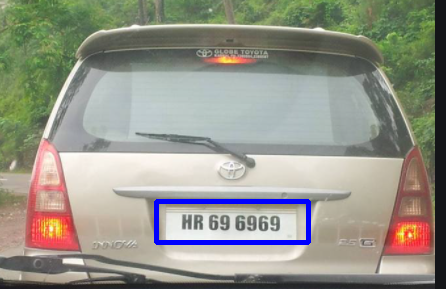

In [ ]:
from google.colab.patches import cv2_imshow
import cv2
img = cv2.imread("/content/drive/MyDrive/Number Plate Recognition/keras-yolo3/Screenshot_61.png")
frame_thickness = 3
color = (255, 0, 0)
file = open('output.txt', 'r')
number_plate = []
for lines in file.readlines():
  line = lines.split(" ") 
  top_left = (int(line[0]), int(line[1])) 
  bottom_right = (int(line[2]), int(line[3]))
  number_plate.append(img[top_left[1]: bottom_right[1], top_left[0]: bottom_right[0]])
  cv2.rectangle(img,top_left,bottom_right, color, frame_thickness)
cv2_imshow(img)


In [ ]:
!pip install easyocr
!pip install imutils

     |████████████████████████████████| 63.2MB 64kB/s 


In [ ]:
import easyocr

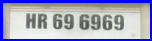

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.




The number plate read by the OCR is <HR 69 6969>


In [ ]:
for numbers in number_plate:
  cv2_imshow(numbers)
  gray = cv2.cvtColor(numbers, cv2.COLOR_BGR2GRAY)
  reader = easyocr.Reader(['en'])
  result = reader.readtext(gray)
  text = result[0][-2]
  print('\n\nThe number plate read by the OCR is <' + text + '>')